In [1]:
## IPython extensions to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
from matplotlib import pyplot as plt

import os
from os.path import join
import sys
from IPython.display import display
from PIL import Image

ROOT_DIR = os.sep.join(os.path.abspath(".").split(os.sep)[:-2])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print(DATASET_DIR)

/home/djoy2409-wsl/projects/software_development/qsar_w_gnns/data


In [3]:
from typing import List, Union, Any, Tuple
from datetime import datetime
from random import sample

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch_geometric
from torch_geometric.data import Data
from torch.nn import BCELoss, BCEWithLogitsLoss, LeakyReLU, ReLU
from torch.optim import lr_scheduler, Adagrad, Adadelta, Adam, AdamW, SGD

from rdkit import Chem, RDLogger
from rdkit.Chem import (
    Draw,
    AllChem,
    PandasTools,
    MolFromSequence,
    MolToSmiles,
    MolToInchiKey,
    Descriptors,
    GraphDescriptors,
)
from rdkit.Chem import rdMolDescriptors as rdmdesc

from joblib import Parallel, delayed

RDLogger.DisableLog("rdApp.*")
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
from lib import (
    gnn_utils,
    utilities,
    datasets,
    splitters,
    featurizers,
    training_utils,
    graph_nns,
    visuals,
)


import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 100
plt.rcParams.update({"font.size": 24})

In [4]:
## Set seeds
seed = 123
utilities.set_seeds(seed=seed)

<p style="font-family: cursive; font-size=14px">
In the following, we will train graph isomorphisms neural network (GIN) models to predict hether a compound inhibits of the growth  <em>P. falciparum's</em> DD2.

Interesting video tutorials about GINs can be founf here:
<ol>
<li><a href="https://www.youtube.com/watch?v=trJwayzmEoU">[Deep Graph Learning] 5.4 Graph Isomorphism Network Expressive nets.</a></li>
<li><a href="https://www.youtube.com/watch?v=f255vMhH4KI">Graph Classification Graph Isomorphism Network | Lecture 85 (Part 5) | Applied Deep Learning.</a></li>
</ol>
</p>

<h3 style="font-family: cursive">Data Preparation</h4>

<h4 style="font-family: cursive">Dataset Cleaning</h4>
<p style="font-family: cursive; font-size=14px">
The dataset was obtained from the PubChem Biossay AID 2302. It was used as example in the paper by [Chakravarti and Mani Alla (2019); Frontiers in Artificial Intelligence, 2, DOI: 10.3389/frai.2019.00017](https://www.frontiersin.org/articles/10.3389/frai.2019.00017/full). </p>


In [5]:
# dd2_data_df   = pd.read_csv(f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302.csv")
smiles_column = "PUBCHEM_EXT_DATASOURCE_SMILES"
# target_column = "PCT_INHIB_DD2"
target_column = "DD2_ACTIVITY_CLS"
mol_column = "RMol"

# print(f"Number of molecules with a missing SMILES string: {dd2_data_df[smiles_column].isna().sum()}/{dd2_data_df.shape[0]}")

# # Removing rows with a missing SMILES string
# dd2_data_df.dropna(subset=[smiles_column], axis=0, inplace=True)


# # Remove rows where is not defined
# dd2_data_df.dropna(subset=['PUBCHEM_ACTIVITY_OUTCOME'], axis=0, inplace=True)

# # Add a column with 0/1 activity values
# dd2_data_df[target_column] = dd2_data_df['PUBCHEM_ACTIVITY_OUTCOME'].apply(lambda x: 1 if x =='Active' else 0)


# # Adding molecule (Mol) objects to the dataframe
# PandasTools.AddMoleculeColumnToFrame(dd2_data_df, smiles_column, mol_column)

# dd2_data_df.head(2)

<span style="font-family: cursive; font-size=16px">
Beside removing rows with an empty SMILES, we will proceed with the following steps:
<ol>
    <li>Select the largest fragment for each molecule, which will also remove slats, among others. We will use the SMILES and inchikeys of the fragment.</li>
    <li>Sanitize the retained molecule</li>
    <li>Fix the target values. Negative values are set to 0 and values greater than 100 are set to 100</li>
    <li>Remove duplicates, using the inchikey as primary key. For each group of duplicates: </li>
        <ol>
            <li>If the min and max values are apart by 20 or more, omit and proceed to the next group</li>
            <li>Else, retain the first occurrence but replace the target value by an average</li>
            <li>It is worth mentioning that duplicate removal is usually a more involved process, where outliers can be detected and removed using a statisical approach, before averaging the taarget value.</li>
        </ol>
</ol>
</span>

In [6]:
# dd2_data_df['largest_frag']        = dd2_data_df[mol_column].apply(utilities.get_largest_fragment_from_mol)

# dd2_data_df['largest_frag_smiles'] = dd2_data_df['largest_frag'].apply(lambda mol: MolToSmiles(utilities.sanitize_molecule(mol, add_explicit_h=True)))

# dd2_data_df.dropna(subset=['largest_frag_smiles'], axis=0, inplace=True)


# dd2_data_df['largest_frag_ikey'] = dd2_data_df['largest_frag'].apply(MolToInchiKey)
# duplicates = dd2_data_df[dd2_data_df.duplicated(subset=['largest_frag_ikey'], keep=False)].sort_values(by='largest_frag_ikey')

# print(f"Number of molecules with a missing largest fragment SMILES string: {dd2_data_df['largest_frag_smiles'].isna().sum()}/{dd2_data_df.shape[0]}")

# print(f"Number of unique inchikeys: {dd2_data_df['largest_frag_ikey'].unique().size}/{dd2_data_df.shape[0]}")
# print(f"Number of duplicates inchikeys: {duplicates.shape[0]} - e.g.: {duplicates.index[:2]}")
# print(f"Number of molecules with a negative target value: {dd2_data_df[dd2_data_df[target_column]<0].shape[0]}/{dd2_data_df.shape[0]} - e.g.:{dd2_data_df[dd2_data_df[target_column]<0].index[:2]}")
# print(f"Number of molecules with target value>100: {dd2_data_df[dd2_data_df[target_column]>100].shape[0]}/{dd2_data_df.shape[0]} - e.g.:{dd2_data_df[dd2_data_df[target_column]>100].index[:2]}")
# dd2_data_df[['PUBCHEM_CID', 'largest_frag_ikey', target_column]].loc[[8,9,272, 458, 11041, 11042],:]

In [7]:
# dd2_data_df['lf_num_frags'] = dd2_data_df['largest_frag'].apply(lambda x: len(Chem.GetMolFrags(x)))
# print(dd2_data_df[dd2_data_df['lf_num_frags']>1])

In [8]:
# print(f" Unique target values = {dd2_data_df[target_column].unique()}")

# dd2_data_df['PUBCHEM_CID'] = dd2_data_df['PUBCHEM_CID'].astype(int)

# dd2_data_df[dd2_data_df.columns.difference([mol_column, 'largest_frag', 'lf_num_frags'])].to_csv(f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302_cleaned.csv")
# dd2_data_df[['PUBCHEM_CID', 'largest_frag_smiles']].to_csv(f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302_largest_frag_cleaned.csv")


# # dd2_data_df.head(2)
dd2_data_df = pd.read_csv(f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302_cleaned.csv")
PandasTools.AddMoleculeColumnToFrame(dd2_data_df, "largest_frag_smiles", "largest_frag")
dd2_data_df.columns

Index(['Unnamed: 0', 'DD2_ACTIVITY_CLS', 'PCT_INHIB_DD2',
       'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_CID',
       'PUBCHEM_EXT_DATASOURCE_SMILES', 'PUBCHEM_SID', 'largest_frag_ikey',
       'largest_frag_smiles', 'largest_frag'],
      dtype='object')

<p style="font-family: cursive; font-size=16px">As you can see, the target values outside of the [0,100] were fixed
    . Moreover, the rows with indices 11041 and 11042 are no longer in the datarame. This is because the corresponding rows have the same inchikeys, but with values that
    are more than 20 % apart. </p>

In [9]:
# atom_list = dd2_data_df['largest_frag'].apply(lambda mol: list(set([atom.GetAtomicNum() for atom in mol.GetAtoms()])))
# atom_list = list(set(utilities.flatten_list(atom_list.values.tolist())))

# print("List of unique atomic numbers: ",  [f"{i}:{Chem.Atom(i).GetSymbol()}" for i in atom_list])

atom_list = [35, 6, 7, 8, 9, 15, 16, 17, 53]

<p style="font-family: cursive; font-size=16px">Instead of defining a long range of values for possible atomic numbers (e.g.: 1-100), which could lead to a very sparse matrix, we can instead focus on the list of atoms that commonly occur in drug-like compounds. Specifically in this set, we notice that only 9 atoms occur in the list of tested compounds. If we add Hydrogen (which will be expicit), we have a vector of length 10 to represent the atomic number, plus 1 additional bit for unknown atomic numbers.</p>
<p style="font-family: cursive; font-size=16px">Le'ts define the atom anf bond featurizers.</p>


In [10]:
atom_featurizer = featurizers.AtomFeaturizer(
    allowable_sets_one_hot={
        "atomic_num": set(atom_list + [1]),
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "formal_charge": {-3, -2, -1, 0, 1, 2, 3},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3", "sp3", "sp3d", "sp3d2"},
        # "chiral_tag": {0, 1, 2, 3},
        "chiral_tag": {
            "chi_unspecified",
            "chi_tetrahedral_cw",
            "chi_tetrahedral_ccw",
            "chi_tetrahedral",
        },  # , "chi_allene", "chi_other"
        "is_aromatic": {True, False},
        "is_in_ring": {True, False},
        "is_in_ring_size_5": {True, False},
        "is_in_ring_size_6": {True, False},
        "is_h_acceptor": {True, False},
        "is_h_donor": {True, False},
        "is_heteroatom": {True, False},
    },
    continuous_props=[
        "atomic_mass",
        "atomic_vdw_radius",
        "atomic_covalent_radius",
        "num_implicit_hydrogens",
        "num_explicit_hydrogens",
        "crippen_log_p_contrib",
        # "crippen_molar_refractivity_contrib",
        # "tpsa_contrib",
        "labute_asa_contrib"
        # ,"gasteiger_charge"
    ],
)

# atom_featurizer = featurizers.ATOM_FEATURIZER

bond_featurizer = featurizers.BondFeaturizer(
    allowable_sets_one_hot={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
        "stereo": {"stereonone", "stereoz", "stereoe", "stereocis", "stereotrans"},
        "is_in_ring": {True, False},
        "is_in_ring_size_5": {True, False},
        "is_in_ring_size_6": {True, False},
    }
)

scale_features = True
feature_scaler = StandardScaler()
# print(dir(feature_scaler))
# print(f"feature_scaler (mean) = {hasattr(feature_scaler, 'mean_')}")

# features_ = None
# features_ = [
#     "CalcExactMolWt",
#     "CalcTPSA",
#     "CalcNumAromaticRings",
#     "CalcNumHBA",
#     "CalcNumHBD",
#     "CalcNumRotatableBonds"
#     # , 'CalcChi0n', 'CalcChi0v', 'CalcChi1n', 'CalcChi1v', 'CalcChi2n', 'CalcChi2v'
#     # , 'CalcChi3n', 'CalcChi3v', 'CalcChi4n', 'CalcChi4v', 'CalcChi0n', 'CalcChi0v'
#     ,
#     "MolLogP",
#     "HallKierAlpha",
#     "qed",
#     "MaxPartialCharge",
#     "MinPartialCharge"
#     # , 'ZagrebIndex'
#     # , 'MoeType'
# ]

features_ = []
mol_featurizer = featurizers.MoleculeFeaturizer(
    features=features_, df_func_gps=featurizers.DF_FUNC_GRPS_RDKIT
)  # featurizers.DF_FUNC_GRPS;  MACCS_FP

In [11]:
print("atom_featurizer feature mapping", atom_featurizer.features_mapping)
print(
    f"atomic_feats_pos_values (atom_featurizer.atomic_feats_pos_values.shape) :\n",
    atom_featurizer.atomic_feats_pos_values.head(5),
)

print("\n\nbond_featurizer feature mapping ", bond_featurizer.features_mapping)
print(
    f"bond_feats_pos_values (bond_featurizer.bond_feats_pos_values.shape) :\n",
    bond_featurizer.bond_feats_pos_values.head(5),
)

print("\n\nmol_featurizer rdkit_features  ", mol_featurizer.rdkit_features)
print("mol_featurizer mordred_features", mol_featurizer.mordred_descs)
print("mol_featurizer func. groups    \n", mol_featurizer.df_func_gps.head(5))

# mol_featurizer.df_func_gps.head(30)
# featurizers.RDKIT_FRAGS
# print(dir(Chem.Fragments))
# Chem.MolToSmarts(Chem.Fragments.fr_aniline.__defaults__[1])

atom_featurizer feature mapping {'atomic_num': {1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 15: 5, 16: 6, 17: 7, 35: 8, 53: 9, 'unk': 10}, 'n_valence': {0: 11, 1: 12, 2: 13, 3: 14, 4: 15, 5: 16, 6: 17, 'unk': 18}, 'formal_charge': {-3: 19, -2: 20, -1: 21, 0: 22, 1: 23, 2: 24, 3: 25, 'unk': 26}, 'n_hydrogens': {0: 27, 1: 28, 2: 29, 3: 30, 4: 31, 'unk': 32}, 'hybridization': {'s': 33, 'sp': 34, 'sp2': 35, 'sp3': 36, 'sp3d': 37, 'sp3d2': 38, 'unk': 39}, 'chiral_tag': {'chi_tetrahedral': 40, 'chi_tetrahedral_ccw': 41, 'chi_tetrahedral_cw': 42, 'chi_unspecified': 43, 'unk': 44}, 'is_aromatic': {False: 45, True: 46, 'unk': 47}, 'is_in_ring': {False: 48, True: 49, 'unk': 50}, 'is_in_ring_size_5': {False: 51, True: 52, 'unk': 53}, 'is_in_ring_size_6': {False: 54, True: 55, 'unk': 56}, 'is_h_acceptor': {False: 57, True: 58, 'unk': 59}, 'is_h_donor': {False: 60, True: 61, 'unk': 62}, 'is_heteroatom': {False: 63, True: 64, 'unk': 65}, 'atomic_mass': 66, 'atomic_vdw_radius': 67, 'atomic_covalent_radius': 68, 'n

In [12]:
# print('atom_featurizer = ', atom_featurizer.features_mapping)
# print('\nbond_featurizer = ', bond_featurizer.features_mapping)

<h4 style="font-family: cursive"> Data splitting</h4>
<p style="font-family: cursive; font-size=16px">We will split the data into train, validation and test sets, using the scaffold splitting method. Small-molecule scaffold splitting, particularly using the Bemis-Murcko scaffold approach, involves identifying and extracting the core structural framework shared among a set of chemical compounds, excluding variable substituents. This process simplifies and abstracts the diverse chemical structures, aiding in the analysis of chemical libraries and structure-activity relationships. The Bemis-Murcko scaffold represents the most conserved structural elements of the compounds.<br/>While scaffold splitting facilitates the identification of key structural motifs,and can enhance model interpretation, it has limitations in handling highly flexible or structurally diverse molecules,and may result in the loss of detailed iformation about specific functional groups or substituents, potentially oversimplifying structure-activity relationships. Moreover, In some cases, scaffold splitting may lead to overly strict splitting criteria, resulting in training, validation, and test sets that are too similar in chemical space.</p>

In [13]:
molecules = dd2_data_df['largest_frag'].values
targets = dd2_data_df[target_column].values

splitter= splitters.ScaffoldSplitter()
train_idx, val_idx, test_idx = splitter.train_val_test_split(molecules=molecules[:], train_ratio=0.85, val_ratio=0.1
                            , test_ratio=0.05, return_as_indices=True, return_as_clusters=False, include_chirality=False
                            , sort_by_size=True, shuffle_idx=True, random_state=seed)

# csplitter = splitters.ClusterSplitter()
# train_idx, val_idx, test_idx = csplitter.train_val_test_split(
#     molecules=molecules[:],
#     train_ratio=0.8,
#     val_ratio=0.15,
#     test_ratio=0.05,
#     return_as_indices=True,
#     return_as_clusters=False,
#     include_chirality=True,
#     sort_by_size=False,
#     shuffle_idx=False,
#     random_state=seed,
#     sim_cutoff=0.5,
# )

# kfold_splits = splitter.kfold_split(molecules=molecules[:50], n_folds=3, return_as_indices=False, include_chirality=False
#                             , random_state=1)
# print(f"fold sizes: {[len(f) for f in kfold_splits]}")

train_mols, y_train = [molecules[i] for i in train_idx], targets[train_idx]
val_mols, y_val = [molecules[i] for i in val_idx], targets[val_idx]
test_mols, y_test = [molecules[i] for i in test_idx], targets[test_idx]

print(
    f"Dataset sizes: Train ({len(train_mols)}) - Validation ({len(val_mols)}) - Test ({len(test_mols)})"
)

Dataset sizes: Train (11492) - Validation (1352) - Test (676)


In [14]:
smiles_and_labels   = {}
largest_frag_smiles = dd2_data_df["largest_frag_smiles"].values
train_smiles        = [largest_frag_smiles[i] for i in train_idx]
val_smiles          = [largest_frag_smiles[i] for i in val_idx]
test_smiles         = [largest_frag_smiles[i] for i in test_idx]

smiles_and_labels["train"] = (train_smiles, y_train)
smiles_and_labels["val"]   = (val_smiles, y_val)
smiles_and_labels["test"]  = (test_smiles, y_test)

pickle.dump(
    smiles_and_labels,
    open(f"{DATASET_DIR}/dd2_cluster_splits_smiles_and_labels_gin.pkl", "wb"),
)

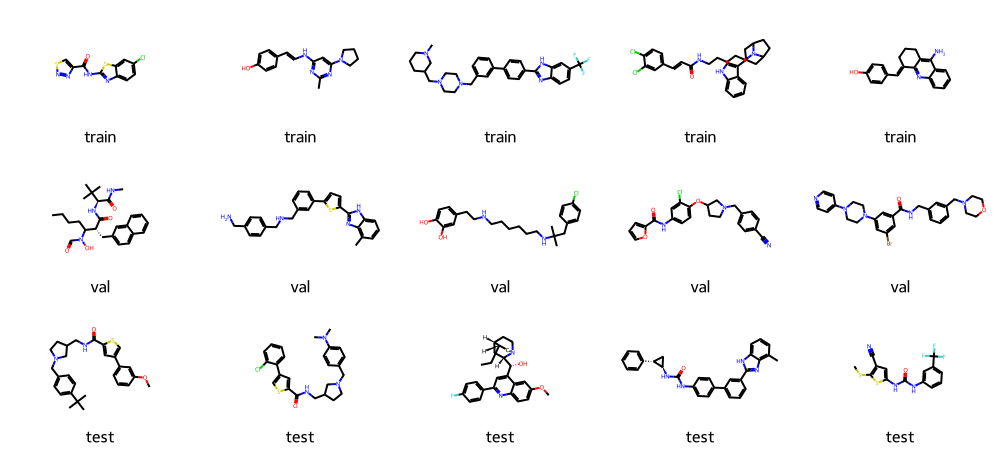

In [15]:
Draw.MolsToGridImage(
    sample(train_mols, 5) + sample(val_mols, 5) + sample(test_mols, 5),
    molsPerRow=5,
    subImgSize=(200, 150),
    legends=["train"] * 5 + ["val"] * 5 + ["test"] * 5,
    highlightAtomLists=None,
)

In [16]:
%%time

train_dataset = gnn_utils.get_dataset_from_mol_list(
    mol_list=train_mols[:],
    targets=y_train[:],
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    mol_featurizer=mol_featurizer,
    add_explicit_h=False,
    compute_global_features=True,
    add_global_feat_to_nodes=False,
    scale_features=scale_features,
    feature_scaler=feature_scaler,
)

# # print(train_dataset[1].x, train_dataset[1].y, train_dataset[1].x[0].shape)
# # if 'global_feats' in train_dataset[1].to_dict():
# #     print(train_dataset[1].global_feats.shape)
# # # train_dataset[1].x[5:10]

# # # s = mol_featurizer.compute_rdkit_properties(train_mols[0])
# # s

Clean features...
global_feats_reshaped (11492, 85)
CPU times: user 3min 27s, sys: 1.18 s, total: 3min 28s
Wall time: 3min 28s


In [17]:
val_dataset = gnn_utils.get_dataset_from_mol_list(
    mol_list=val_mols,
    targets=y_val,
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    mol_featurizer=mol_featurizer,
    add_explicit_h=False,
    compute_global_features=True,
    add_global_feat_to_nodes=False,
    scale_features=scale_features,
    feature_scaler=feature_scaler,
)

test_dataset = gnn_utils.get_dataset_from_mol_list(
    mol_list=test_mols,
    targets=y_test,
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    mol_featurizer=mol_featurizer,
    add_explicit_h=False,
    compute_global_features=True,
    add_global_feat_to_nodes=False,
    scale_features=scale_features,
    feature_scaler=feature_scaler,
)

Clean features...
global_feats_reshaped (1352, 85)
Clean features...
global_feats_reshaped (676, 85)


In [19]:
dd2_dataset_fname = f"{DATASET_DIR}/dd2_datasets_gin.pt"
torch.save(
    {
        "splitter": splitter.__class__.__name__,
        "train": train_dataset,
        "val": val_dataset,
        "test": test_dataset,
    },
    dd2_dataset_fname,
)
# train_dataset[0]

In [ ]:
# dd2_dataset_fname = f"{DATASET_DIR}/dd2_datasets_gat.pt"
# dd2_dataset = torch.load(dd2_dataset_fname)

# train_dataset = dd2_dataset["train_dataset"]
# val_dataset = dd2_dataset["val_dataset"]
# test_dataset = dd2_dataset["test_dataset"]

In [24]:
batch_size = 1024
train_loader, val_loader, test_loader = datasets.get_dataloaders(
    train_data=train_dataset,
    test_data=test_dataset,
    val_data=val_dataset,
    batch_size=batch_size,
    shuffle_train=True,
    add_global_feats_to_nodes=False,
    num_workers=0,
)


dd2_loader_fname = f"{DATASET_DIR}/dd2_dataloaders_for_gin.pt"
torch.save(
    {
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader,
    },
    dd2_loader_fname,
)
# list(train_loader)[0].x.shape

In [ ]:
# dd2_loader_fname = f"{DATASET_DIR}/dd2_dataloaders_for_gat.pt"
# dd2_loaders = torch.load(dd2_loader_fname)

# train_loader = dd2_loaders["train_loader"]
# val_loader = dd2_loaders["val_loader"]
# test_loader = dd2_loaders["test_loader"]

<h3 style="font-family: cursive">Implementing a Graph Isomorphism Network model</h3>
<p style="font-family: cursive">
A Graph Isomorphism Network (GIN) is a type of Graph Neural Network (GNN) that aggregates information from neighboring nodes and edges to learn node representations. GIN differs from other GNNs like Graph Attention Networks (GATs) and Graph Convolutional Networks (GCNs) by employing a readout function that integrates global graph-level information, allowing GIN to be more permutation invariant and capture graph isomorphism. GIN has been shown to be expressive and flexible, making it suitable for tasks where capturing structural similarities in graphs is crucial.</p>
<ol>
<li><a href="https://arxiv.org/abs/1810.00826">How Powerful are Graph Neural Networks?</li>
<li><a href="https://github.com/weihua916/powerful-gnns">How Powerful are Graph Neural Networks? (GitHub)</li>
<li><a href="https://medium.com/@mymomo119966.mm/graph-neural-networks-regressive-modelling-by-example-b13055bf56e8">Graph Isomorphism Neural Networks — Drug Discovery Example</li>
<li><a href="https://towardsdatascience.com/how-to-design-the-most-powerful-graph-neural-network-3d18b07a6e66">GIN: How to Design the Most Powerful Graph Neural Network</li>
</ol>

<h3 style="font-family: cursive">Creating and Training a model</h3>

In [25]:
%%time
import sklearn
from torch.optim import lr_scheduler
from optuna.samplers import TPESampler

in_channels = list(train_loader)[0].x[0].shape[0]
global_fdim = (
    list(train_loader)[0].global_feats.shape[1]
    if "global_feats" in list(train_loader)[0].to_dict()
    else None
)
criterion = BCEWithLogitsLoss()

exp_params_grid = {
    "task": "binary_classification",
    "in_channels": in_channels,
    "global_fdim": global_fdim,
    "model": ["graph_nns.GIN"],
    "gnn_hidden_neurons": [150, 250],
    "gnn_nlayers": [2, 2]
    # , 'ffn_hidden_neurons': [64, 128, 256, 384, 512]
    ,
    "ffn_hidden_neurons": [100, 150],
    "ffn_nlayers": [1, 2],
    "out_neurons": 1,
    "dropout_rate": [0.1, 0.3],
    "activation_func": ["torch.nn.LeakyReLU", "torch.nn.ReLU"],
    "gpooling_func": ["mean"],
    # 'learning_rate': [5e-2, 1e-1],
    # , 'n_epochs': [10, 20],
    "learning_rate": [5e-2, 1e-1],
    "n_epochs": [150, 200],
    "criterion": criterion,
    "optimizer": ["{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}"],
    # "scheduler": [
    #     "{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.8, 'patience':25, 'threshold':1e-02, 'eps':1e-08}"
    # ],
    'scheduler' : ["{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':50, 'cycle_momentum':True}"],
    "scoring_func": ["roc_auc_score"],
    "add_batch_norm": True,
}

my_hpo = training_utils.OptunaHPO(n_trials=5, n_jobs=1, sampler=TPESampler(), add_tboard_writer=True
                                    , n_startup_trials=1, n_warmup_steps=25
                                    , tboard_log_dir = f"{DATASET_DIR}/logs_dd2_gin_tensorboard")
print(my_hpo.tboard_writer)

results = my_hpo.run_optimization(
    train_val_data=[train_loader, val_loader],
    params_grid=exp_params_grid,
    optuna_direction="maximize",
    split_mode="classic",
    study_name="my_gin_study",
)
# print("best_model = ", my_hpo.best_model)
results

[I 2024-11-09 15:13:29,727] A new study created in memory with name: my_gin_study


params = {'task': 'binary_classification', 'in_channels': 73, 'global_fdim': 85, 'model': 'graph_nns.GIN', 'gnn_hidden_neurons': 246, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 116, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.2939702693002407, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.06342284731320141, 'n_epochs': 200, 'criterion': BCEWithLogitsLoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':50, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}

in_channels = 73 :: gnn_dim = 246 :: activation_func = ReLU()
Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.06342284731320141, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1

[I 2024-11-09 15:19:15,978] Trial 0 finished with value: 0.8668668757632065 and parameters: {'in_channels': 73, 'global_fdim': 85, 'model': 'graph_nns.GIN', 'gnn_hidden_neurons': 246, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 116, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.2939702693002407, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.06342284731320141, 'n_epochs': 200, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':50, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.8668668757632065.



===> Epoch  200/200: Average Train Loss: 0.566 |  Average validation Loss: 0.480 | Validation Score: 0.867 | lr: 0.06615
params = {'task': 'binary_classification', 'in_channels': 73, 'global_fdim': 85, 'model': 'graph_nns.GIN', 'gnn_hidden_neurons': 230, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 132, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.15760672217997232, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.07210828907039195, 'n_epochs': 150, 'criterion': BCEWithLogitsLoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':50, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}

in_channels = 73 :: gnn_dim = 230 :: activation_func = ReLU()
Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.07210828907039195, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov':

[I 2024-11-09 15:20:05,769] Trial 1 pruned. 


params = {'task': 'binary_classification', 'in_channels': 73, 'global_fdim': 85, 'model': 'graph_nns.GIN', 'gnn_hidden_neurons': 150, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 132, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.2420800646558768, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'learning_rate': 0.08215374633349012, 'n_epochs': 150, 'criterion': BCEWithLogitsLoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':50, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}

in_channels = 73 :: gnn_dim = 150 :: activation_func = LeakyReLU(negative_slope=0.01)
Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.08215374633349012, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4,

[I 2024-11-09 15:20:41,316] Trial 2 pruned. 


params = {'task': 'binary_classification', 'in_channels': 73, 'global_fdim': 85, 'model': 'graph_nns.GIN', 'gnn_hidden_neurons': 166, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 148, 'ffn_nlayers': 1, 'out_neurons': 1, 'dropout_rate': 0.18838460358455122, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.06871810305548509, 'n_epochs': 200, 'criterion': BCEWithLogitsLoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':50, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}

in_channels = 73 :: gnn_dim = 166 :: activation_func = ReLU()
Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.06871810305548509, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

[I 2024-11-09 15:25:11,828] Trial 3 finished with value: 0.6237970047812798 and parameters: {'in_channels': 73, 'global_fdim': 85, 'model': 'graph_nns.GIN', 'gnn_hidden_neurons': 166, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 148, 'ffn_nlayers': 1, 'out_neurons': 1, 'dropout_rate': 0.18838460358455122, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.06871810305548509, 'n_epochs': 200, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':50, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.8668668757632065.



===> Epoch  200/200: Average Train Loss: 0.613 |  Average validation Loss: 0.646 | Validation Score: 0.624 | lr: 0.07134
params = {'task': 'binary_classification', 'in_channels': 73, 'global_fdim': 85, 'model': 'graph_nns.GIN', 'gnn_hidden_neurons': 214, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 148, 'ffn_nlayers': 1, 'out_neurons': 1, 'dropout_rate': 0.22202550239911306, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.07433003151691177, 'n_epochs': 150, 'criterion': BCEWithLogitsLoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':50, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}

in_channels = 73 :: gnn_dim = 214 :: activation_func = ReLU()
Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.07433003151691177, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov':

[I 2024-11-09 15:28:51,935] Trial 4 finished with value: 0.6147754481330486 and parameters: {'in_channels': 73, 'global_fdim': 85, 'model': 'graph_nns.GIN', 'gnn_hidden_neurons': 214, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 148, 'ffn_nlayers': 1, 'out_neurons': 1, 'dropout_rate': 0.22202550239911306, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'learning_rate': 0.07433003151691177, 'n_epochs': 150, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':50, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.8668668757632065.



===> Epoch  150/150: Average Train Loss: 0.630 |  Average validation Loss: 0.649 | Validation Score: 0.615 | lr: 0.19749
CPU times: user 15min 9s, sys: 15.8 s, total: 15min 25s
Wall time: 15min 24s


{'best_params': {'in_channels': 73,
  'global_fdim': 85,
  'model': 'graph_nns.GIN',
  'gnn_hidden_neurons': 246,
  'gnn_nlayers': 2,
  'ffn_hidden_neurons': 116,
  'ffn_nlayers': 2,
  'out_neurons': 1,
  'dropout_rate': 0.2939702693002407,
  'activation_func': 'torch.nn.ReLU',
  'gpooling_func': 'mean',
  'learning_rate': 0.06342284731320141,
  'n_epochs': 200,
  'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}",
  'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.2, 'step_size_up':50, 'cycle_momentum':True}",
  'scoring_func': 'roc_auc_score'},
 'best_score': 0.8668668757632065}

<h3 style="font-family: cursive">Evaluating The Best Model</h3>

<h4 style="font-family: cursive"> Visualizing Losses and Scores</h4>

In [ ]:
%%time
best_params = results["best_params"]
gin_model = my_hpo.best_model
train_losses, val_losses, val_scores = (
    my_hpo.train_val_metadata["train_losses"],
    my_hpo.train_val_metadata["val_losses"],
    my_hpo.train_val_metadata["val_scores"],
)

In [ ]:
# list(gin_model.state_dict().keys())

In [ ]:
visuals.plots_train_val_metrics(
    train_losses=train_losses,
    val_scores=val_scores,
    val_losses=val_losses,
    figsize=(10, 7),
    image_pathname=f"{DATASET_DIR}/models/dd2_class_gnn_stats_gin.jpeg",
    val_score_name=best_params["scoring_func"],
)

In [33]:
torch.save(gin_model.state_dict(), f"{DATASET_DIR}/models/dd2_class_gin_model.pt")

: 

<h4 style="font-family: cursive"> Model Evaluation</h4>

In [28]:
from lib import predictions

test_pred, test_true = predictions.predict_from_loader(
    loader=test_loader,
    model=gin_model,
    device="cuda:0",
    return_class_as_proba=True,
    return_true_targets=True,
    desc="Predicting...",
)

threshold = 0.5
test_pred_classes = [int(x > threshold) for x in test_pred.squeeze(1)]


print("nr. of predictions = ", len(test_true))
print(
    f"\nROC AUC Score = {round(roc_auc_score(test_true.cpu(), test_pred.detach().cpu()),3)}"
)
print(
    f"Balanced Acc. = {round(balanced_accuracy_score(test_true.cpu(), test_pred_classes),3)}"
)
print(f"F1-Score      = {round(f1_score(test_true.cpu(), test_pred_classes),3)}")
print(f"Precision     = {round(precision_score(test_true.cpu(), test_pred_classes),3)}")
print(f"Recall        = {round(recall_score(test_true.cpu(), test_pred_classes),3)}")

nr. of predictions =  676

ROC AUC Score = 0.735
Balanced Acc. = 0.681
F1-Score      = 0.764
Precision     = 0.707
Recall        = 0.831


<h5 style="font-family: cursive"> Evaluate using the GNNPredictor</h5>

In [29]:
gin_predictor = predictions.GNNPredictor(
    model=gin_model,
    atom_featurizer=atom_featurizer,
    bond_featurizer=bond_featurizer,
    add_explicit_h=True,
    mol_featurizer=mol_featurizer,
    scale_features=True,
    feature_scaler=StandardScaler(),
    compute_global_features=True,
    add_global_feats_to_nodes=False,
)

In [30]:
# gin_model = torch.load(f"{DATASET_DIR}/models/dd2_class_gin_model.pt")
torch.save(gin_predictor, f"{DATASET_DIR}/models/dd2_class_gin_predictor.pt")

In [ ]:
# gin_predictor=torch.load(f"{DATASET_DIR}/models/dd2_class_gin_predictor.pt")
# gin_predictor

# dd2_loader_fname = f'{DATASET_DIR}/dd2_dataloaders.pt'
# dd2_loaders = torch.load(dd2_loader_fname)

# train_loader = dd2_loaders['train_loader']
# val_loader   = dd2_loaders['val_loader']
# test_loader  = dd2_loaders['test_loader']

In [31]:
test_pred, test_true = gin_predictor.predict_from_loader(
    loader=test_loader,
    return_class_as_proba=True,
    device="cuda:0",
    return_true_targets=True,
    desc="Predicting...",
)



threshold = 0.5
test_pred_classes = [int(x > threshold) for x in test_pred.squeeze(1)]
print(test_pred_classes)

print(
    f"\nROC AUC Score = {round(roc_auc_score(test_true.cpu(), test_pred.detach().cpu()),3)}"
)
print(
    f"Balanced Acc. = {round(balanced_accuracy_score(test_true.cpu(), test_pred_classes),3)}"
)
print(f"F1-Score      = {round(f1_score(test_true.cpu(), test_pred_classes),3)}")
print(f"Precision     = {round(precision_score(test_true.cpu(), test_pred_classes),3)}")
print(f"Recall        = {round(recall_score(test_true.cpu(), test_pred_classes),3)}")

[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<h5 style="font-family: cursive"> Predict DD2 Activity from SMILES</h5>

In [32]:
smiles = ["CCC(=O)NCc1nccc1CO", "O=C(O)c1cccnc1Sc1cc(CCO)c(Cl)cc1"]
new_preds = gin_predictor.predict_from_smiles_list(
    smiles_list=smiles, device="cuda:0", desc="Predicting...",
    return_class_as_proba=True,
)



threshold = 0.5
pred_classes = [int(x > threshold) for x in new_preds.squeeze(1)]
print("\nnew_preds", new_preds)
print("pred_classes", pred_classes)

Clean features...
add_global_feats_to_nodes False
loader:  DataBatch(x=[33, 73], edge_index=[2, 101], edge_attr=[101, 24], global_feats=[2, 85], batch=[33], ptr=[3])

new_preds tensor([[0.6008],
        [0.6740]], device='cuda:0', grad_fn=<CatBackward0>)
pred_classes [1, 1]
